In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

2023-10-02 20:54:17.620758: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 20:54:17.674705: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 20:54:17.676320: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 20:54:18.790147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. Data preparation 
Input datat: [Open, Close, Max, Min, Volume]*14 days.

Output: Candlestick of 15th day.

In [25]:
df = pd.read_csv("./600029.SS.csv",parse_dates=["Date"],index_col=[0])[['Open','Close','High','Low','Volume']]
df = df.iloc[::-1]
# Split test and train
ntest = round(len(df)*0.10)  # 20% are test set
df_for_training=df[:-ntest]
df_for_testing=df[-ntest:]

print(df_for_training.shape,'(number of data for training, dim)')
print(df_for_testing.shape,'(number of data for test, dim)')

(1247, 5) (number of data for training, dim)
(138, 5) (number of data for test, dim)


In [26]:
# Scale the data by using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)

In [39]:
# Use previous 30 days data to predict 31st day open price
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0:4])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,14)
testX,testY=createXY(df_for_testing_scaled,14)

In [47]:
# Define a function to create the LSTM model
from tensorflow.keras.optimizers import SGD

def create_lstm_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(14, 5)))
    #model.add(LSTM(units=units, return_sequences=True))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=50, activation='ReLU'))
    model.add(Dropout(0.1))
    model.add(Dense(units=4, activation='linear'))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

Model = create_lstm_model()
Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 14, 50)            11200     
                                                                 
 lstm_7 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 204       
                                                                 
Total params: 76854 (300.21 KB)
Trainable params: 7685

In [ ]:
#callback = tensorflow.keras.callbacks.EarlyStopping(monitor='adams', patience=8)

Model.compile(optimizer='adam', loss='mean_squared_error')
history = Model.fit(trainX,  # Input features
                    trainY,  # Target labels
                    epochs=400,  # Number of training iterations
                    batch_size=20,  # Mini-batch size (optional)
                    #callbacks=[callback],  # Early stop
                    validation_split=0.1,)  # Validation data (optional)

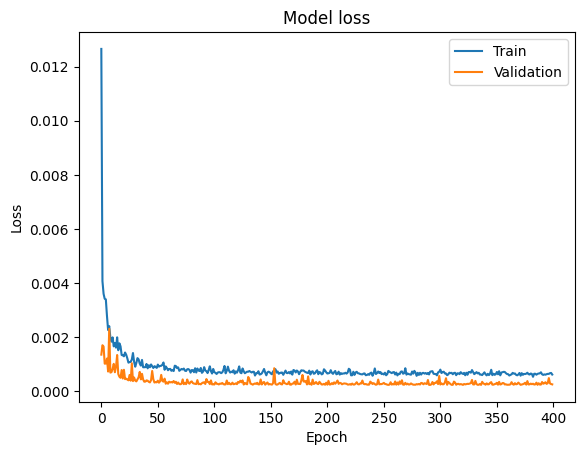

In [50]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [51]:
trainY[-1]

array([0.34010152, 0.33759594, 0.33417404, 0.36413798])

In [52]:
prediction=Model.predict(testX)
#prediction = prediction.reshape((len(prediction),1))
print("prediction\n", )
print("\nPrediction Shape-",prediction.shape)
prediction.shape

4/4 [==============================] - 1s 10ms/step
prediction


Prediction Shape- (124, 4)


(124, 4)

(124, 5)
(124, 5)


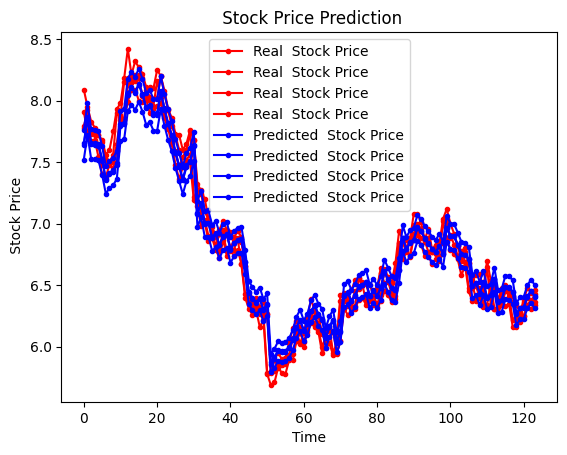

In [71]:
'''
prediction_copies_array = np.repeat(prediction,5, axis=-1)
print(prediction_copies_array.shape)
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),20)))[:,0:4]

original_copies_array = np.repeat(testY,5, axis=-1)
print(original_copies_array.shape)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),20)))[:,0:4]
'''

prediction_copies_array = np.hstack((prediction, np.zeros((len(prediction),1)) ))
print(prediction_copies_array.shape)
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0:4]

original_copies_array = np.hstack((testY, np.zeros((len(testY),1)) ))
print(original_copies_array.shape)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0:4]


import matplotlib.pyplot as plt
plt.plot(original, '.-', color = 'red', label = 'Real  Stock Price')
plt.plot(pred, '.-',color = 'blue', label = 'Predicted  Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

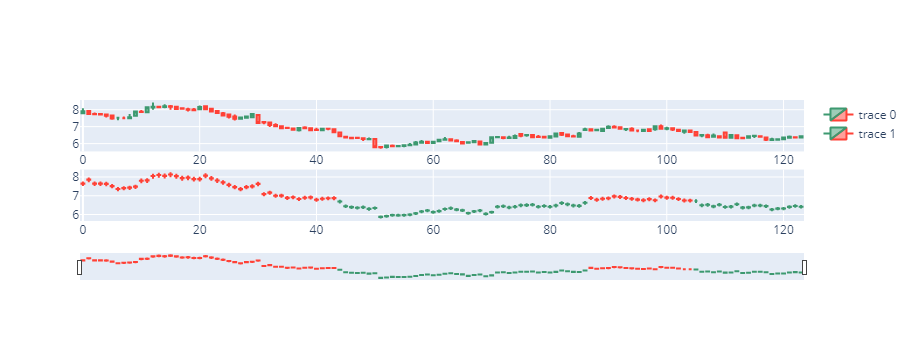

In [84]:
import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=1)

fig = fig.add_trace(go.Candlestick(
                open=original[:,0], high=original[:,2],
                low=original[:,3], close=original[:,1])
                ,row=1, col=1)

fig = fig.add_trace(go.Candlestick(
                open=pred[:,0], high=pred[:,2],
                low=pred[:,3], close=pred[:,1])
                ,row=2, col=1)

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [85]:
pred

array([[7.65443286, 7.64268711, 7.76207042, 7.52127339],
       [7.8632814 , 7.85273044, 7.97711637, 7.72420682],
       [7.65924431, 7.64772784, 7.76737183, 7.52590781],
       [7.6547499 , 7.64298146, 7.76209618, 7.52193088],
       [7.64589775, 7.63366605, 7.75204449, 7.51385538],
       [7.5259598 , 7.51297965, 7.62824577, 7.39758571],
       [7.36700234, 7.35464474, 7.4662158 , 7.24383795],
       [7.41434138, 7.40106051, 7.51328022, 7.28970138],
       [7.43542223, 7.42165504, 7.53390636, 7.31062551],
       [7.4919375 , 7.47842214, 7.5920465 , 7.36561452],
       [7.80767708, 7.79626002, 7.91815616, 7.67184216],
       [7.82162037, 7.81050499, 7.93340527, 7.68480055],
       [8.05791469, 8.04825752, 8.17738445, 7.91378646],
       [8.11160739, 8.10261741, 8.23382252, 7.96505609],
       [8.07053935, 8.061189  , 8.19144576, 7.92491087],
       [8.1375476 , 8.12826782, 8.25990275, 7.9899902 ],
       [8.05645374, 8.04676085, 8.1764949 , 7.91101648],
       [7.94625447, 7.93608925,

In [ ]:
r'zs.(\d+)\', r'SZ.\1'